In [4]:
import re
import pandas as pd
import tensorflow as tf
from keras.datasets import mnist
import cv2
import os
import pathlib
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score

In [7]:
dataset_path = '/Users/sallu/Desktop/original'
day_folders = ['Day4', 'Day5', 'Day7', 'Day10']

subfolder_pattern = re.compile(r'CRI_D(\d+)_(\d+|(?:cntrl|ctrl|contr))_\d+_\d+_\d+')

file_paths = []
labels = []
days_of_infestation = []
number_of_flies = []

for day_folder in day_folders:
    folder_path = os.path.join(dataset_path, day_folder)
    
    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        
        if subfolder.startswith('.') or not os.path.isdir(subfolder_path):
            continue
        
        match = subfolder_pattern.match(subfolder)
        if match:
            day_of_infestation = int(match.group(1))
            flies_or_control = match.group(2)

            if flies_or_control in ['cntrl', 'ctrl', 'contr']:
                label = 'not_infested'
                flies = 0
                day_of_infestation = 0
            else:
                label = 'infested'
                flies = int(flies_or_control)
        else:
            continue
        
        for filename in os.listdir(subfolder_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                file_path = os.path.join(subfolder_path, filename)
                file_paths.append(file_path)
                labels.append(label)  
                days_of_infestation.append(day_of_infestation)  
                number_of_flies.append(flies)  

df = pd.DataFrame({
    'Image': file_paths,
    'Days of infestation': days_of_infestation,
    'Number of flies': number_of_flies,
    'Label': labels
})

In [8]:
df

,Image,Days of infestation,Number of flies,Label
0,/Users/sallu/Desktop/original/Day4/CRI_D4_500_...,4,500,infested
1,/Users/sallu/Desktop/original/Day4/CRI_D4_500_...,4,500,infested
2,/Users/sallu/Desktop/original/Day4/CRI_D4_500_...,4,500,infested
3,/Users/sallu/Desktop/original/Day4/CRI_D4_500_...,4,500,infested
4,/Users/sallu/Desktop/original/Day4/CRI_D4_500_...,4,500,infested
...,...,...,...,...
9715,/Users/sallu/Desktop/original/Day10/CRI_D10_50...,10,50,infested
9716,/Users/sallu/Desktop/original/Day10/CRI_D10_50...,10,50,infested
9717,/Users/sallu/Desktop/original/Day10/CRI_D10_50...,10,50,infested
9718,/Users/sallu/Desktop/original/Day10/CRI_D10_50...,10,50,infested


In [9]:
class ReadDataset:
    def __init__(self, dataframe, image_shape):
        self.dataframe = dataframe
        self.image_shape = image_shape
        self.label_mapping = self._create_label_mapping()

    def _create_label_mapping(self):
        labels = self.dataframe['Label'].unique()
        label_mapping = {label: idx for idx, label in enumerate(labels)}
        return label_mapping

    def readImages(self):
        self.finalImages = []
        labels = []
        
        for idx, row in self.dataframe.iterrows():
            img_path = row['Image']
            label = self.label_mapping[row['Label']]
            
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, self.image_shape)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img / 255.0  # Normalizzare le immagini tra 0 e 1
                self.finalImages.append(img)
                labels.append(label)
            else:
                print(f"Immagine non trovata: {img_path}")
                
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [10]:
dataset = ReadDataset(dataframe=df, image_shape=(64, 64))

In [50]:
print(images.shape)
print(labels.shape)

(9720, 64, 64, 3)
(9720,)


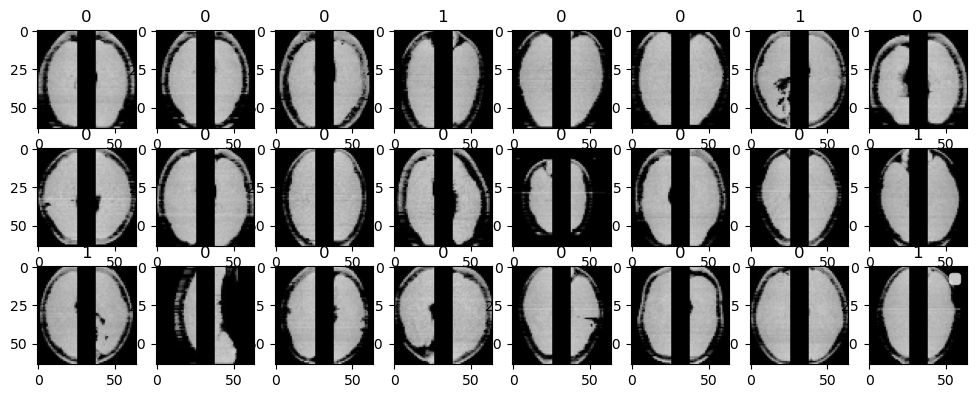

In [51]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(labels), size = (24, ))
for i in range(24):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[indexs[i]])
    plt.title(labels[indexs[i]])
plt.legend()

In [52]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain
    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis = 1)
        plt.figure(figsize = (12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap = 'gray')
            plt.title(ys[i])
        plt.show()
    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(1024, )(x)
        x = layers.Dense(8*8*filters[0],
                         kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = LayerNormalization()(x)
            x = layers.Activation('relu')(x)
            x = Conv2DTranspose(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides)(x)
        x = Conv2DTranspose(3, kernel_size = self.kernel_size, padding = padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs = [inputs, labels],
                                           outputs = x,
                                           name = 'generator')
    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size = self.kernel_size, padding = padding,
                      strides = strides,
                      kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha = 0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1, )(x)
        labelsOutput = Dense(256,
                             kernel_regularizer = tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2,)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs = inputs,
                                               outputs = [outputs, labelsOutput],
                                               name = 'discriminator')
    def build(self,):
        generatorInput = layers.Input(shape = (self.latent_space))
        discriminatorInput = layers.Input(shape = (self.image_shape))
        labelsInput = layers.Input(shape = (2, ))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss = ['mse', 'binary_crossentropy'],
                 optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta,
                                                        weight_decay = self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs = [generatorInput, labelsInput],
                           outputs = D(G([generatorInput, labelsInput])))
        GAN.compile(loss = ['mse', 'binary_crossentropy'],
                   optimizer = tf.keras.optimizers.RMSprop(learning_rate = self.eta*0.5,
                                                          weight_decay = self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN
    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size = (self.batch_size, ))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape = (self.batch_size, ))
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size = (self.batch_size)),
                                                      num_classes = 2)
            fakeImages = tf.squeeze(G.predict([noize, fakeLabels], verbose = 0))
            fakeTag = tf.zeros(shape = (self.batch_size, ))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape = (self.batch_size,
                                              self.latent_space), minval = -1,
                                     maxval = 1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 5000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag,
                                                                                                                dlossLabels,
                                                                                                                glossTag,
                                                                                                                glossLabels))
                self.samples(G, noize, fakeLabels)

In [53]:
acgan = Acgan(eta = 0.0001, batch_size = 32, epochs = 32000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 3), kernel_size = 5)

In [54]:
acgan.data(images, labels)

In [55]:
G, D, GAN = acgan.build()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 32, 32, 32)           2432      ['input_8[0][0]']             
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 32)           0         ['conv2d_8[0][0]']            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 16, 16, 64)           51264     ['leaky_re_lu_8[0][0]']       
                                                                                      

 activation_15 (Activation)  (None, 64, 64, 64)           0         ['layer_normalization_11[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_transpose_13 (Conv2  (None, 64, 64, 32)           51232     ['activation_15[0][0]']       
 DTranspose)                                                                                      
                                                                                                  
 conv2d_transpose_14 (Conv2  (None, 64, 64, 3)            2403      ['conv2d_transpose_13[0][0]'] 
 DTranspose)                                                                                      
                                                                                                  
 activation_16 (Activation)  (None, 64, 64, 3)            0         ['conv2d_transpose_14[0][0]'] 
          

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 generator (Functional)      (None, 64, 64, 3)            1961696   ['input_7[0][0]',             
                                                          3          'input_9[0][0]']             
                                                                                                  
 discriminator (Functional)  [(None, 1),                  5289539   ['generator[0][0]']     

Epoch: 0
discriminator loss: [tag: 0.4997813403606415, labels: 0.6925967931747437], generator loss: [tag: 0.485857754945755, labels: 0.7162045240402222]
1/1 [==============================] - 0s 12ms/step


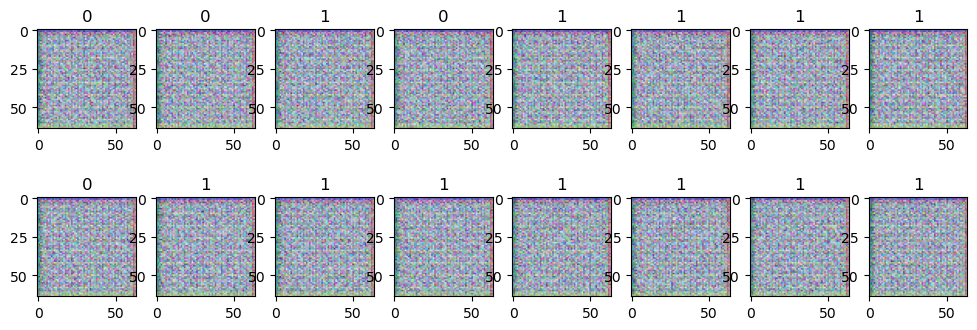

Epoch: 5000
discriminator loss: [tag: 0.2159631997346878, labels: 0.09904070943593979], generator loss: [tag: 0.22505788505077362, labels: 0.11028948426246643]
1/1 [==============================] - 0s 13ms/step


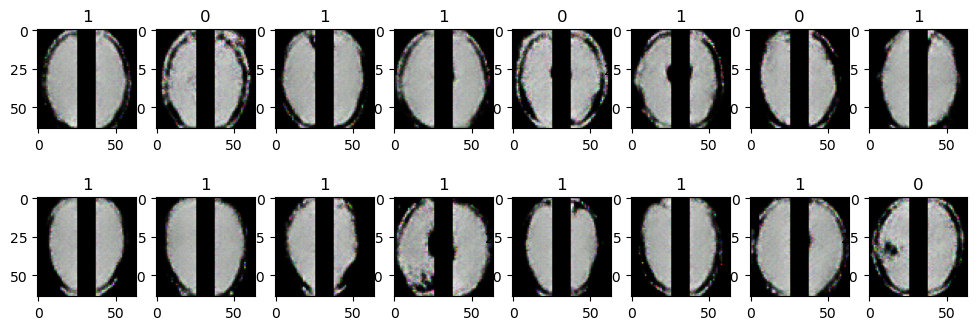

Epoch: 10000
discriminator loss: [tag: 0.22696800529956818, labels: 0.010958850383758545], generator loss: [tag: 0.33581840991973877, labels: 0.006850991398096085]
1/1 [==============================] - 0s 13ms/step


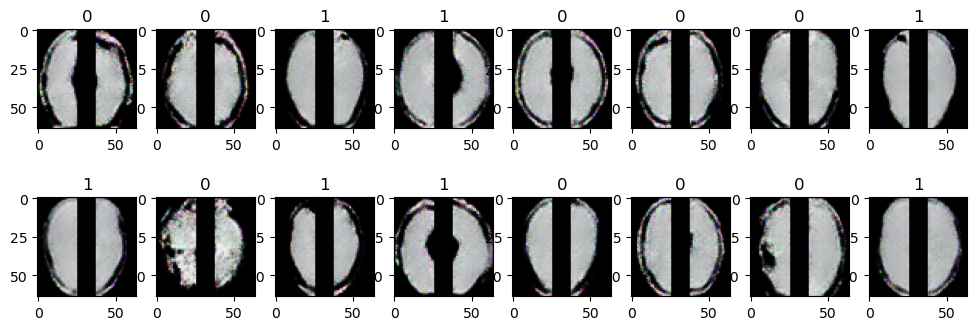

Epoch: 15000
discriminator loss: [tag: 0.20764529705047607, labels: 0.02136719413101673], generator loss: [tag: 0.49570244550704956, labels: 0.001273715985007584]
1/1 [==============================] - 0s 13ms/step


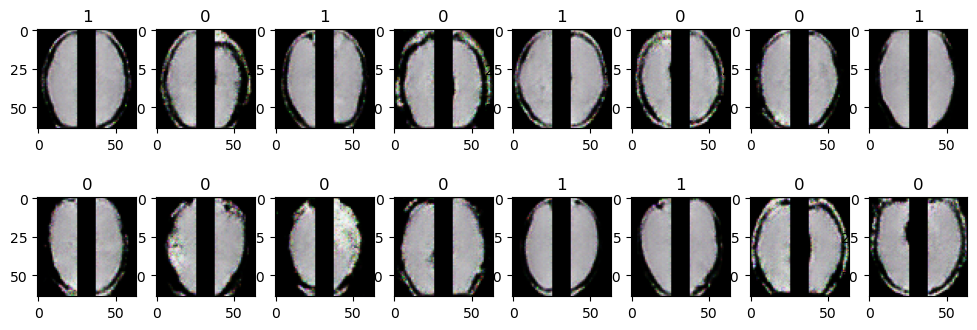

Epoch: 20000
discriminator loss: [tag: 0.20101815462112427, labels: 0.008207748644053936], generator loss: [tag: 0.3181937336921692, labels: 0.018221139907836914]
1/1 [==============================] - 0s 13ms/step


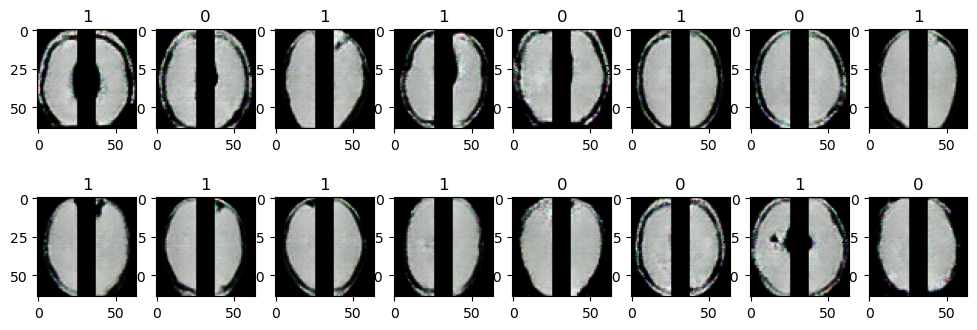

Epoch: 25000
discriminator loss: [tag: 0.1633639931678772, labels: 0.036394357681274414], generator loss: [tag: 0.4617979824542999, labels: 0.010042166337370872]
1/1 [==============================] - 0s 8ms/step


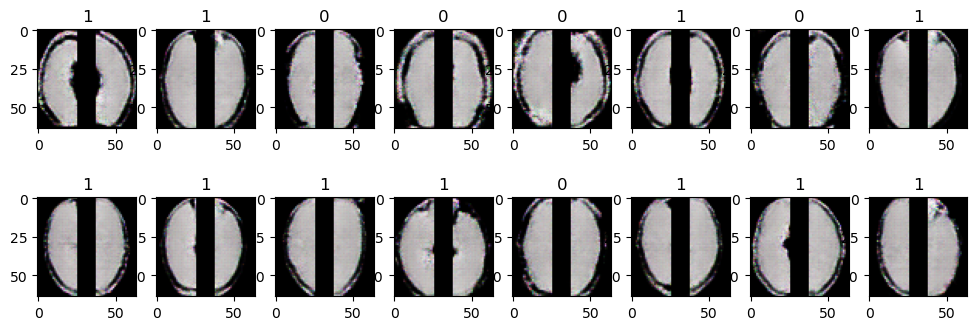

Epoch: 30000
discriminator loss: [tag: 0.21841950714588165, labels: 0.002866341732442379], generator loss: [tag: 0.4508184492588043, labels: 0.003217685967683792]
1/1 [==============================] - 0s 21ms/step


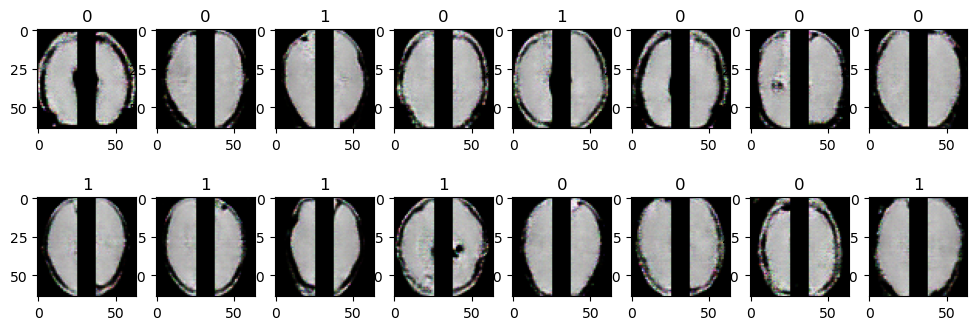

In [56]:
acgan.trainAlgorithm(G, D, GAN)

In [57]:
G.save('generator.h5')

/Users/sallu/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
G = tf.keras.models.load_model('generator.h5')

2024-07-20 17:50:20.625796: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-20 17:50:20.625824: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-20 17:50:20.625833: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-20 17:50:20.626326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-20 17:50:20.626767: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
datasetGenerationSize = 30000
noize = tf.random.uniform(shape=(datasetGenerationSize, 100), minval=-1, maxval=1)
#newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [6]:
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size=(datasetGenerationSize,)), num_classes=2)

In [7]:
noize.shape, newlabels.shape

(TensorShape([30000, 100]), (30000, 2))

In [8]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1]), array([14915, 15085]))

In [9]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

2024-07-14 10:29:06.079755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 161s 170ms/step


(30000, 64, 64, 3)

In [10]:
C = tf.keras.models.load_model('vgg16_label_classification.h5')  

In [11]:
predicted_labels = C.predict(imagesGeneration)
predicted_labels = np.argmax(predicted_labels, axis=1)

938/938 [==============================] - 50s 53ms/step


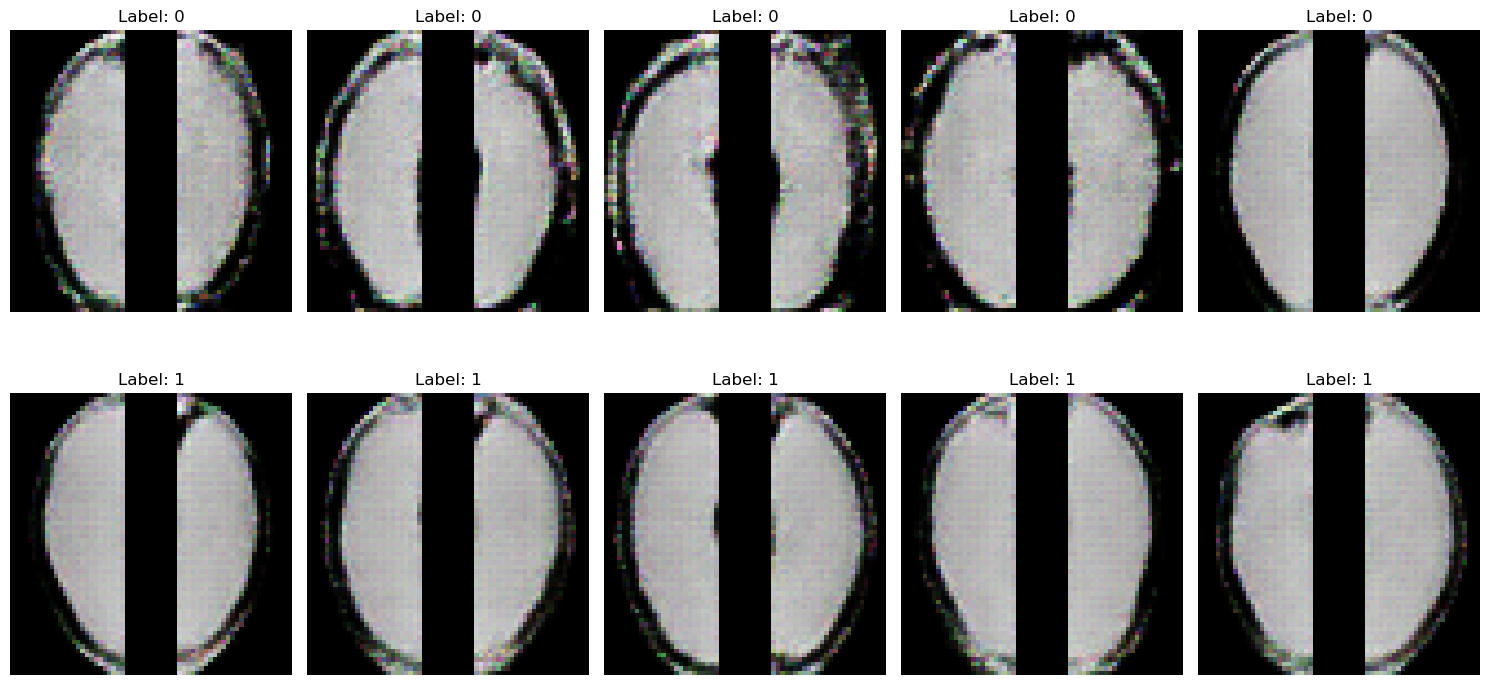

In [18]:
import matplotlib.pyplot as plt

label_0_indices = np.where(predicted_labels == 0)[0]
label_1_indices = np.where(predicted_labels == 1)[0]

label_0_images = imagesGeneration[label_0_indices]
label_1_images = imagesGeneration[label_1_indices]

num_images_to_display = min(5, min(len(label_0_images), len(label_1_images)))  

subset_images = np.concatenate([label_0_images[:num_images_to_display], label_1_images[:num_images_to_display]], axis=0)
subset_labels = np.concatenate([np.zeros(num_images_to_display), np.ones(num_images_to_display)], axis=0)

plt.figure(figsize=(15, 8))

for i in range(2 * num_images_to_display):
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(subset_images[i])
    plt.title(f"Label: {int(subset_labels[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()
